In [ ]:
# To install open cv if not present
# pip install opencv-python

In [ ]:
# To install skimage if not present
# pip install scikit-image

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [2]:
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import os, random
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, InputLayer, Dropout
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input


Using TensorFlow backend.


In [4]:
root_dir = 'E:\Github\DeepLearning-videoAnalysis'

## Extracting frames from video

In [5]:
count = 0
cap = cv2.VideoCapture('video.mp4')   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

print ("Frame extraction complete")

Frame extraction complete


In [5]:
# Function to display random images from directory

img_width, img_height = 224, 224
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()

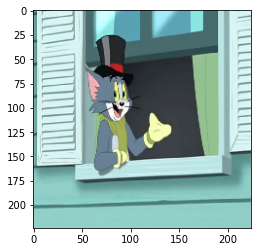

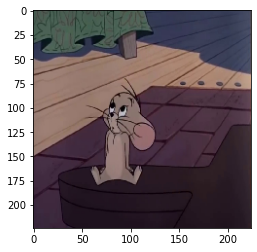

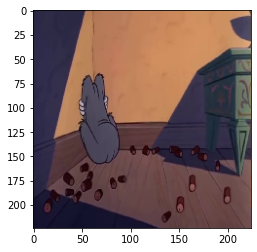

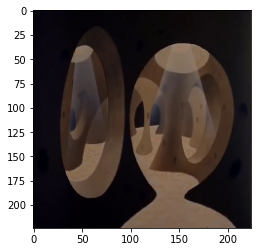

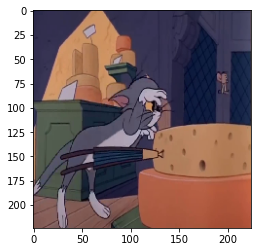

In [8]:
# Displaying images
files = root_dir+'/frames'
for i in range(0,5):
    show_pictures(files)

## Label a few images for training the model

In [6]:
# 0 – neither JERRY nor TOM
# 1 – for JERRY
# 2 – for TOM
csv = os.path.join(root_dir,"frames\mapping.csv")
data = pd.read_csv(csv)     # reading the csv file
data.head()      # printing first five rows of the file

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,2


In [7]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    a = os.path.join(root_dir,"frames",img_name)
    img = plt.imread('' + a)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [8]:
y = data.Class
dummy_y = np_utils.to_categorical(y)    # one hot encoding Classes

In [9]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [10]:
X = preprocess_input(X, mode='tf')      # preprocessing the input data

In [11]:
# Splitting data into train ,validation and test
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Model building

In [12]:
image_input = Input(shape=(224, 224, 3))
base_model = VGG16(input_tensor=image_input, include_top=False,weights='imagenet')
# include_top=False to remove the top layer

In [13]:
X_train = base_model.predict(X_train)
X_val = base_model.predict(X_val)
X_test_predict = base_model.predict(X_test)
X_train.shape, X_val.shape, X_test_predict.shape

((178, 7, 7, 512), (60, 7, 7, 512), (60, 7, 7, 512))

In [14]:
X_train = X_train.reshape(178, 7*7*512)      # converting to 1-D
X_val = X_val.reshape(60, 7*7*512)
X_test = X_test_predict.reshape(60, 7*7*512)

In [15]:
train = X_train/X_train.max()      # centering the data
X_val = X_val/X_train.max()
X_test = X_test/X_train.max()

In [16]:
# Building the model
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(3, activation='softmax'))    # output layer

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________


## Model Compiling and Training

In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# Training the model
history = model.fit(train, y_train, epochs=100, validation_data=(X_val, y_val))

Train on 178 samples, validate on 60 samples
Epoch 1/100
178/178 [==============================] - 1s 4ms/sample - loss: 1.1743 - accuracy: 0.5000 - val_loss: 0.7213 - val_accuracy: 0.7167
Epoch 2/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.5580 - accuracy: 0.7640 - val_loss: 0.4340 - val_accuracy: 0.8333
Epoch 3/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.2598 - accuracy: 0.8876 - val_loss: 0.4563 - val_accuracy: 0.8000
Epoch 4/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.1685 - accuracy: 0.9607 - val_loss: 0.3000 - val_accuracy: 0.9000
Epoch 5/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0981 - accuracy: 0.9775 - val_loss: 0.3868 - val_accuracy: 0.8333
Epoch 6/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0762 - accuracy: 0.9888 - val_loss: 0.2804 - val_accuracy: 0.9167
Epoch 7/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0517 -

Epoch 57/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0125 - accuracy: 0.9944 - val_loss: 0.2044 - val_accuracy: 0.9333
Epoch 58/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0418 - accuracy: 0.9944 - val_loss: 0.2058 - val_accuracy: 0.9333
Epoch 59/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0287 - accuracy: 0.9944 - val_loss: 0.3359 - val_accuracy: 0.9000
Epoch 60/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0284 - accuracy: 0.9888 - val_loss: 0.3929 - val_accuracy: 0.8833
Epoch 61/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0155 - accuracy: 0.9944 - val_loss: 0.2389 - val_accuracy: 0.9333
Epoch 62/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0127 - accuracy: 0.9944 - val_loss: 0.2237 - val_accuracy: 0.9333
Epoch 63/100
178/178 [==============================] - 0s 1ms/sample - loss: 0.0191 - accuracy: 0.9888 - val_loss: 0.2534 -

## Evaluation

Text(0.5, 1.0, 'Accuracy Curves')

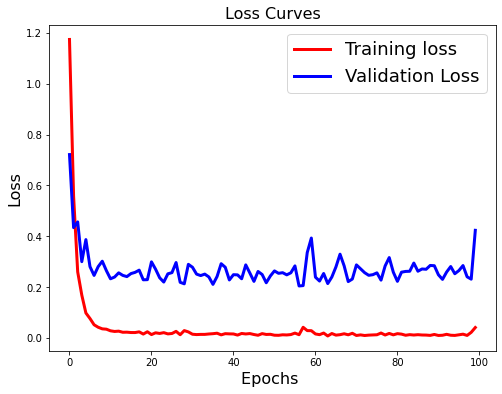

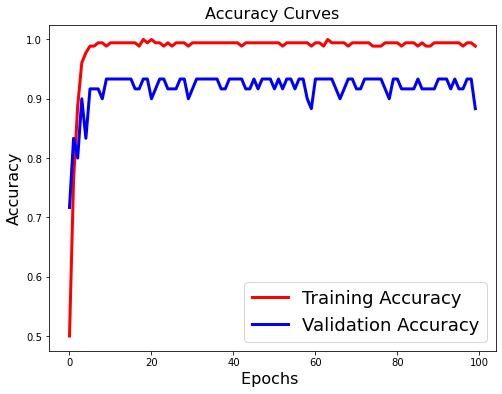

In [20]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [21]:
y_pred = model.predict(X_test)

In [22]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [23]:
confusion_matrix(y_test,y_pred)

array([[20,  0,  6],
       [ 0, 10,  2],
       [ 0,  0, 22]], dtype=int64)

In [24]:
t = PrettyTable(['Accuracy3','Precision','Recall','F1 Score'])
t.add_row(["{:.2%}".format(accuracy_score(y_test, y_pred)),"{:.2%}".format(precision_score(y_test, y_pred, average='macro')),"{:.2%}".format(recall_score(y_test, y_pred, average='macro')),"{:.2%}".format(f1_score(y_test, y_pred, average='macro'))])
print(t) 

+-----------+-----------+--------+----------+
| Accuracy3 | Precision | Recall | F1 Score |
+-----------+-----------+--------+----------+
|   86.67%  |   91.11%  | 86.75% |  87.49%  |
+-----------+-----------+--------+----------+


## Calculating Screen-time

In [25]:
count = 0
videoFile = "screentime.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [30]:
test_image = []
for img_name in test.Image_ID:
    a = os.path.join(root_dir,"test",img_name)
    img = plt.imread('' + a)
    test_image.append(img)
test_img = np.array(test_image)

In [31]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [32]:
# preprocessing the images
test_image = preprocess_input(test_image, mode='tf')

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(186, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [33]:
predictions = model.predict_classes(test_image)

In [34]:
print("The screen time of JERRY is", predictions[predictions==1].shape[0], "seconds")
print("The screen time of TOM is", predictions[predictions==2].shape[0], "seconds")

The screen time of JERRY is 4 seconds
The screen time of TOM is 162 seconds
